In [1]:
import os

from imp import reload
import numpy as np
import pandas as pd
import scipy.stats as sts
import scipy.special as spc
import matplotlib.pyplot as plt
import seaborn as sns
import mergeeyedata as med

sns.set_style('white')

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 40)

%matplotlib inline

In [11]:
reload(med);

In [12]:
inits = [f[:2] for f in os.listdir(med.m_dir) if f[-3:]=='csv']

mouse = []
eye = []

for i, ii in enumerate(inits[:]): 
    mouse.append(med.Mouse(ii, sub_no=i))
    eye.append(med.Eye(ii, sub_no=i))

KeyboardInterrupt: 

In [7]:
mH = mouse[0].H.loc[:, list(range(36))]
eH = eye[0].H.loc[mH.index, list(range(36))]
offset = .0000000001

Q = (mH.values+offset) / mH.values.sum(axis=1)[:, np.newaxis]
P = eH.values / eH.values.sum(axis=1)[:, np.newaxis]

Qp1 = np.random.dirichlet((1,)*36, size=213) # benchmark 1
Qp2 = (eH.values[::-1]+offset) / eH.values.sum(axis=1)[:, np.newaxis] # benchmark 2

def cross_entropy(P, Q):
    H = P * np.log(Q)
    H = H.sum(axis=1)
    return -H

np.nanmean(cross_entropy(P, Qp2))

19.453015357922588

/Users/gianni/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gianni/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


tile x:  0.553799495988 raw  x:  0.575932466433 
 tile y:  0.288014975158 raw  y:  0.307082037666
tile x:  -0.0402655716483 raw  x:  -0.0506570845231 
 tile y:  0.0391612149708 raw  y:  0.0380447056977
tile x:  0.480313504237 raw  x:  0.48258370141 
 tile y:  0.222555333448 raw  y:  0.239597968296
tile x:  0.14657839644 raw  x:  0.148406261396 
 tile y:  0.000522335943381 raw  y:  -0.0011447911766
tile x:  0.086476656257 raw  x:  0.0973122694116 
 tile y:  -0.0270681195064 raw  y:  -0.0475552618727
tile x:  0.383842337618 raw  x:  0.392973203795 
 tile y:  0.210528083125 raw  y:  0.240879335192
tile x:  0.423864683012 raw  x:  0.436498220278 
 tile y:  0.133977658462 raw  y:  0.138448575045
tile x:  0.0688210986066 raw  x:  0.0659827542344 
 tile y:  -0.0507750794826 raw  y:  -0.0449905012852
tile x:  0.0328349655159 raw  x:  0.0344265768269 
 tile y:  -0.023512832664 raw  y:  -0.0245947079311
tile x:  0.44766332183 raw  x:  0.461314770041 
 tile y:  0.156153891901 raw  y:  0.162488568

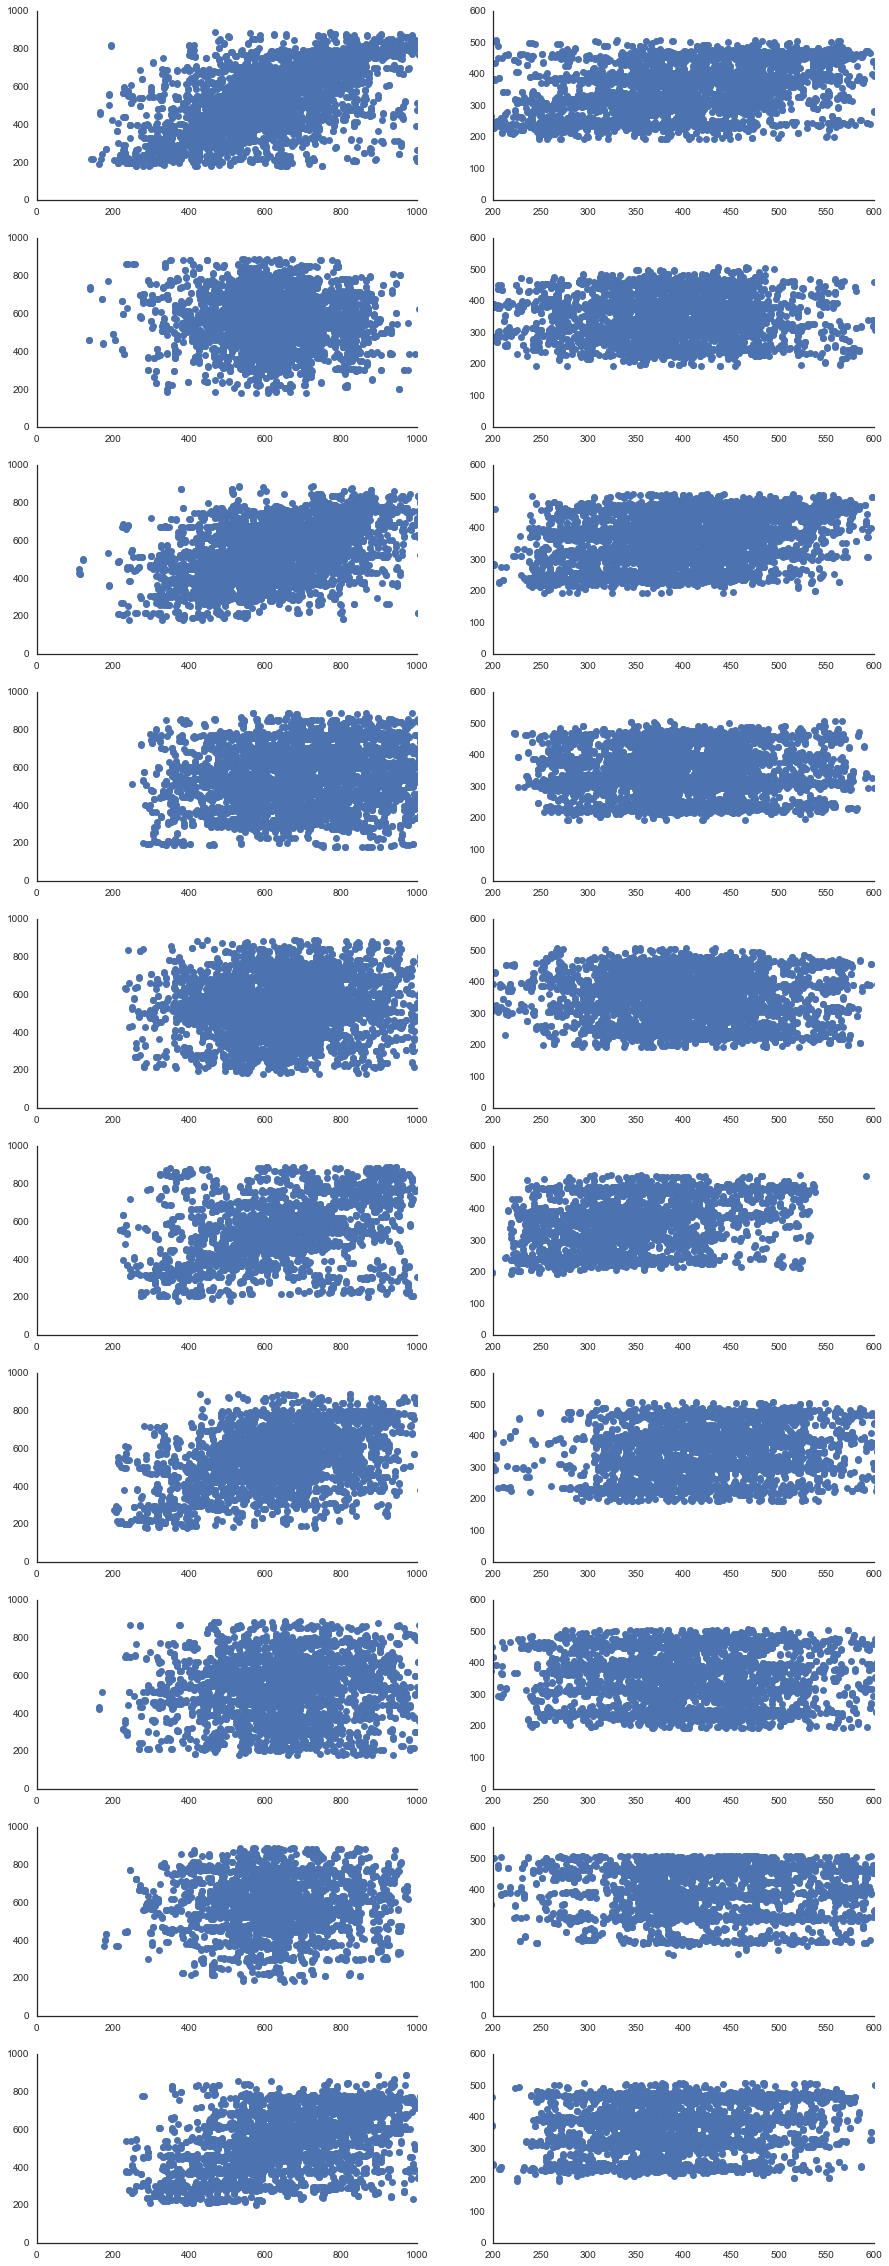

In [8]:
def merge_tables(idx):
    mT = mouse[idx].T.copy()
    eT = eye[idx].T.copy()
    eT.columns = ['tstamp'] + list('e' + eT.columns.values[1:])
    mT.columns = ['tstamp'] + list('m' + mT.columns.values[1:])
    D = pd.concat((mT, eT))
    D = D.sort_values('tstamp')
    D = D.fillna(method='ffill', limit=1)

    D.loc[(D.mdt>=250)&(D.edt>=250), ['ex', 'mx']].values
    return D

fig, axes = plt.subplots(len(mouse), 2, figsize=(15, len(mouse)*4), sharex=False, sharey=False)
for i in range(len(mouse)):
    
    D = merge_tables(i)
    D2 = D.loc[pd.notnull(D.ex)&pd.notnull(D.mx), :]
    
    D2.loc[:, 'etilex'], D2.loc[:, 'mtilex'] = D2.etile % 9, D2.mtile % 9
    D2.etiley, D2.mtiley = D2.etile // 9, D2.mtile // 9
    
    print(
        'tile x: ', sts.linregress(D2.etilex.values, D2.mtilex.values).rvalue,
        'raw  x: ', sts.linregress(D2.ex.values, D2.mx.values).rvalue, '\n',
        'tile y: ', sts.linregress(D2.etiley.values, D2.mtiley.values).rvalue,
        'raw  y: ', sts.linregress(D2.ey.values, D2.my.values).rvalue
    )
    
    ax = axes[i, 0]
    ax.plot(D.ex.values, D.mx.values, marker='o', linestyle='None')
    plt.setp(ax, xlim=[0, 1000], ylim=[0, 1000])

    ax = axes[i, 1]
    ax.plot(D.ey.values, D.my.values, marker='o', linestyle='None')
    plt.setp(ax, xlim=[200, 600], ylim=[0, 600])

sns.despine()

In [9]:
for i in range(len(mouse)):
    mH = mouse[i].H
    eH = eye[i].H
    mT = mouse[i].T
    eT = eye[i].T

    ex = eH.rt.values
    ey = eH.loc[:, list(range(36))].sum(axis=1).values
    
    mx = mH.rt.values
    my = mH.loc[:, list(range(36))].sum(axis=1).values
    print(
        sts.linregress(ex, ey).rvalue,
        sts.linregress(mx, my).rvalue
    )


0.986687115883 0.954129796932
0.898773438605 0.08753371622
0.997698011857 0.946179544935
0.992879455669 0.992771333872
0.94111637055 0.957717385829
0.994081087622 0.555230461884
0.984425935067 0.265859504763
0.977808034933 0.877355267556
0.9718819541 0.821036779798
0.985527788859 0.96293711158


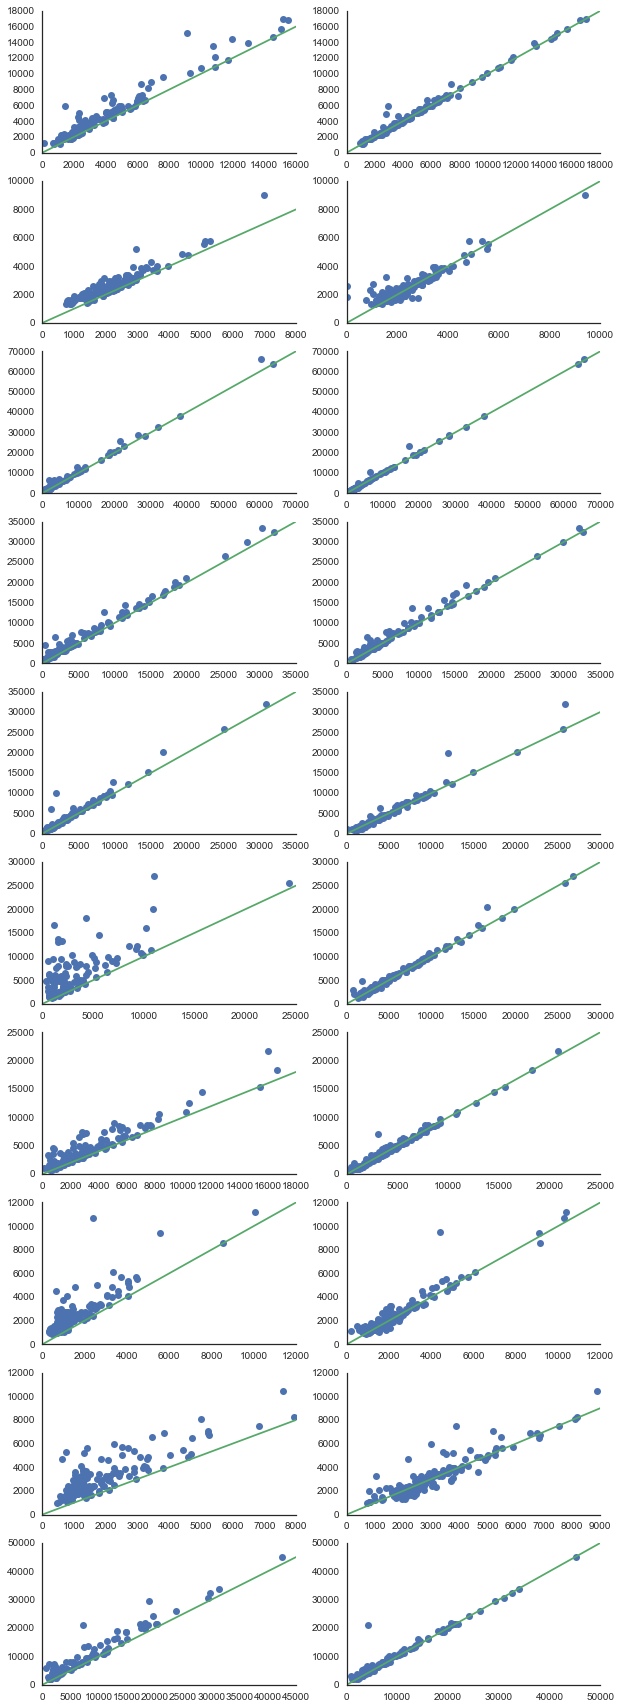

In [10]:
fig, axes = plt.subplots(len(mouse), 2, figsize=(10, len(mouse)*3))
for i in range(len(mouse)):
    mH = mouse[i].H
    mH = mH.loc[mH.status=='playing', :]
    eH = eye[i].H
    eH = eH.loc[eH.status=='playing', :]
    
    ax = axes[i, 0]
    ax.plot(mH.loc[:, list(range(36))].sum(axis=1), mH.rt, marker='o', linestyle='None')
    ax.plot(ax.get_xlim(), ax.get_xlim())
    
    ax = axes[i, 1]
    ax.plot(eH.loc[:, list(range(36))].sum(axis=1), eH.rt, marker='o', linestyle='None')
    ax.plot(ax.get_xlim(), ax.get_xlim())
    
sns.despine()

In [17]:
mH = mouse[1].H
mH = mH.loc[mH.status=='playing', :]
dif = mH.loc[:, list(range(36))].sum(axis=1) - mH.rt
np.mean(dif.values**2)**.5

574.31981652701927

In [18]:
dif

gi
37.0     -997
38.0     -377
39.0     -938
40.0     -581
41.0     -845
42.0    -1209
43.0     -418
46.0     -320
47.0        4
48.0       -1
49.0     -761
50.0     -598
52.0     -264
53.0     -111
54.0      -76
55.0     -793
56.0     -505
57.0     -485
58.0      -80
59.0     -172
60.0     -695
63.0     -141
64.0      -48
65.0     -262
66.0     -315
67.0     -409
68.0      -20
70.0     -154
71.0     -349
72.0     -258
73.0      -80
74.0     -512
75.0      -13
76.0     -716
77.0    -1112
79.0     -506
80.0      -91
81.0     -676
82.0     -474
83.0     -499
84.0     -308
85.0     -220
88.0     -298
89.0     -715
90.0     -404
91.0     -431
92.0     -477
94.0    -2284
95.0     -789
96.0     -402
97.0      -20
98.0     -231
99.0     -649
100.0   -1112
101.0    -760
103.0    -328
104.0    -653
105.0    -455
106.0    -869
107.0    -571
108.0    -546
109.0    -803
112.0    -461
113.0    -272
114.0       2
115.0    -637
116.0    -348
117.0    -325
118.0       1
119.0    -759
122.0    -272
123

In [14]:
mG = mouse[1].G
mG.loc[216]

subid                                              1429288452145
color                                                          1
gi                                                            21
mi                                                             0
status                                                    eyecal
bp                          000000000000000000000000000000000000
wp                          100000000000000000000000000000000000
zet                                                            0
rt                                                          1516
tstamp                                             1429289874492
mouset         1429289772637,1429289772670,1429289772678,1429...
mousex         469,307;469,306;471,306;471,305;473,305;474,30...
rt_comp                                                   100344
tstamp_comp                                        1429289872976
subject                                                        1
Name: 216, dtype: object